# Heart Disease Prediction

## Source file

https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved from https://www.kaggle.com/fedesoriano/heart-failure-prediction.

## Feature info


    Age: age of the patient [years]
    Sex: sex of the patient [M: Male, F: Female]
    ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
    RestingBP: resting blood pressure [mm Hg]
    Cholesterol: serum cholesterol [mm/dl]
    FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
    RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
    MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
    ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
    Oldpeak: oldpeak = ST [Numeric value measured in depression]
    ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
    HeartDisease: output class [1: heart disease, 0: Normal]


## Library import and EDA

In [56]:
# library imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
raw_data = pd.read_csv('heart.csv')

In [3]:
raw_data.sample(5)

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
647   37   F           NAP        120          215          0     Normal   
241   54   M           ASY        200          198          0     Normal   
320   59   M           NAP        125            0          1     Normal   
644   71   F           NAP        110          265          1        LVH   
447   77   M           ASY        124          171          0         ST   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
647    170              N      0.0       Up             0  
241    142              Y      2.0     Flat             1  
320    175              N      2.6     Flat             1  
644    130              N      0.0       Up             0  
447    110              Y      2.0       Up             1

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
raw_data.describe()

Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000

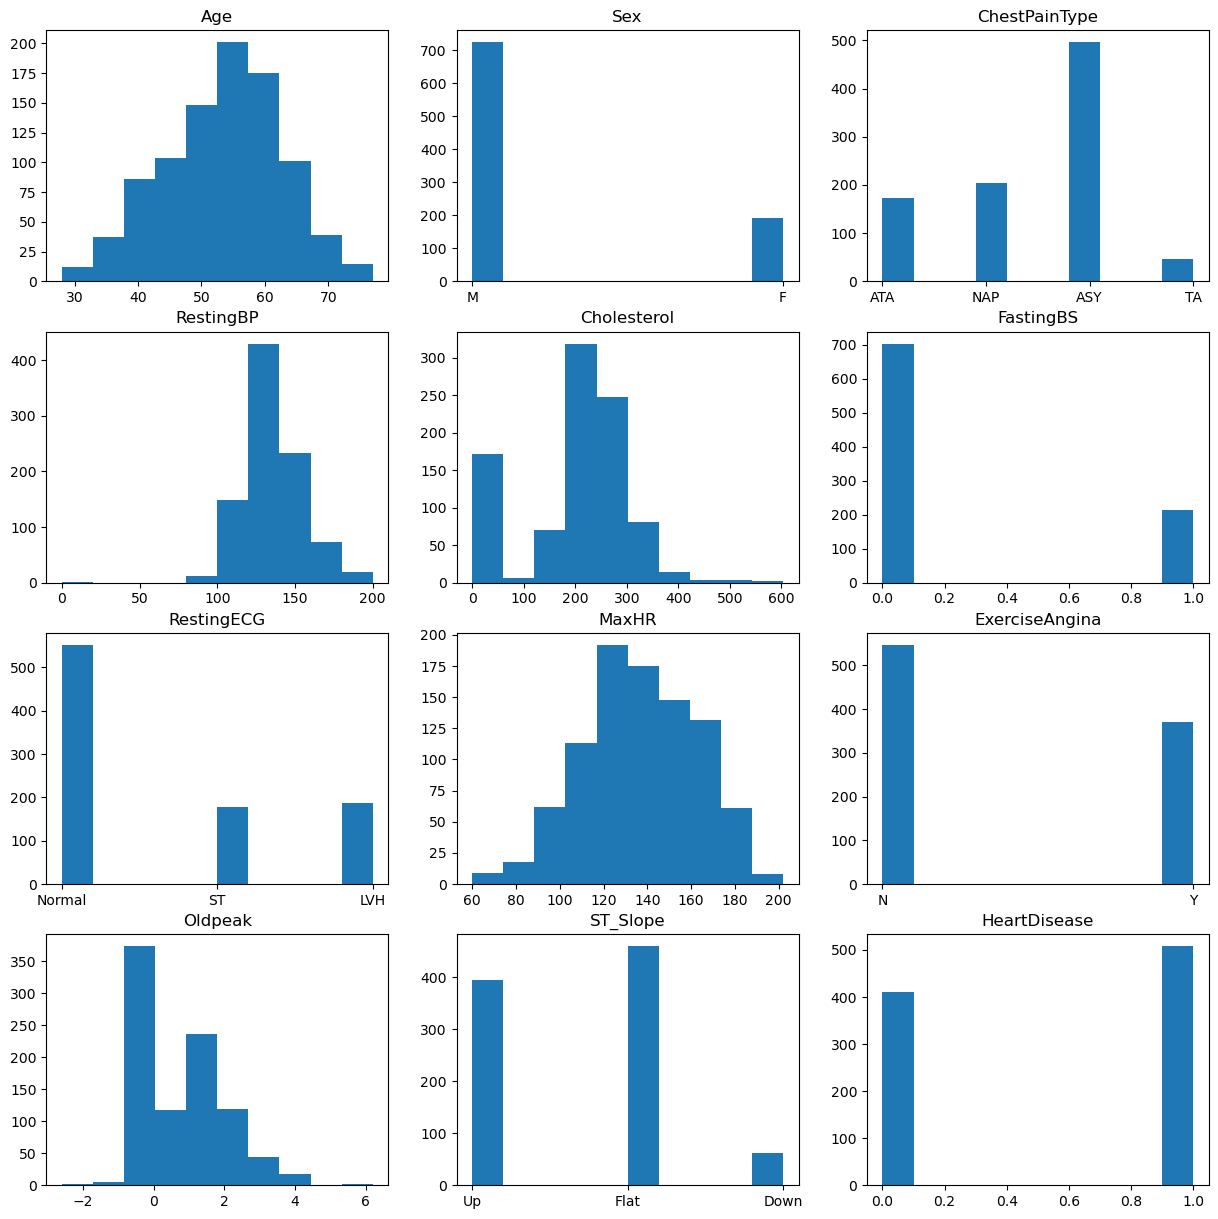

In [6]:
fig, ax = plt.subplots(4,3,figsize=(15,15))

i = 0
j = 0
for k, col in enumerate(raw_data.columns):
    ax[i][j].hist(raw_data[col])
    ax[i][j].set_title(col)
    j += 1
    if j == 3:
        j = 0
        i += 1

In [7]:
# checking for duplicate data
raw_data.duplicated().sum()

0

## Data manipulation for model

In [8]:
def label_encoding(dataframe: pd.DataFrame):
    df = dataframe.copy()
    code_dict = {}
    for col in df.columns:
        if df[col].dtype == object or df[col].dtype == str:
            le = LabelEncoder()
            label = le.fit(df[col])
            transform_label = le.transform(df[col])
            df.drop(col, axis=1, inplace=True)
            df[col] = transform_label
            df[col] = df[col].astype('int')
            # storing the encoding dict 
            code_dict[col] = [list(le.classes_), list(le.transform(le.classes_))]
    return df, code_dict

df, code_dict = label_encoding(raw_data)

int64
object
object
int64
int64
int64
object
int64
object
float64
object
int64


In [9]:
code_dict

{'Sex': [['F', 'M'], [0, 1]],
 'ChestPainType': [['ASY', 'ATA', 'NAP', 'TA'], [0, 1, 2, 3]],
 'RestingECG': [['LVH', 'Normal', 'ST'], [0, 1, 2]],
 'ExerciseAngina': [['N', 'Y'], [0, 1]],
 'ST_Slope': [['Down', 'Flat', 'Up'], [0, 1, 2]]}

## Model Preparation

### Train test split

In [10]:
X = df.drop('HeartDisease',axis=1)

y = df['HeartDisease']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

### Standardization of non categorical variables

In [35]:
numerical_cols = []
for col in raw_data.columns:
    if raw_data[col].dtype in ['int64','int32','float64']:
        numerical_cols.append(col)
numerical_cols.remove('HeartDisease')
numerical_cols

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

In [46]:
scaler = StandardScaler()

X_train_scaled = X_train
X_test_scaled = X_test

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

## Model Fitting

In [48]:
rf_scaled = RandomForestClassifier()

rf_scaled.fit(X_train_scaled,y_train)

RandomForestClassifier()

## Model Evaluation

In [49]:
y_pred_scaled = rf_scaled.predict(X_test_scaled)

In [52]:
acc_scaled = accuracy_score(y_test,y_pred_scaled)

acc_scaled

0.8712871287128713

In [53]:
print(classification_report(y_test,y_pred_scaled))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       136
           1       0.87      0.90      0.88       167

    accuracy                           0.87       303
   macro avg       0.87      0.87      0.87       303
weighted avg       0.87      0.87      0.87       303



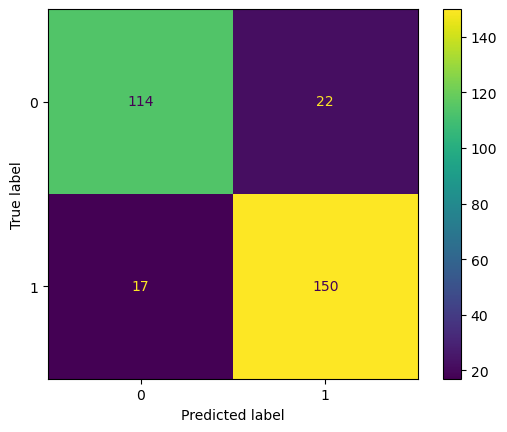

In [54]:
cm = confusion_matrix(y_test, y_pred_scaled)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

## Feature Importance

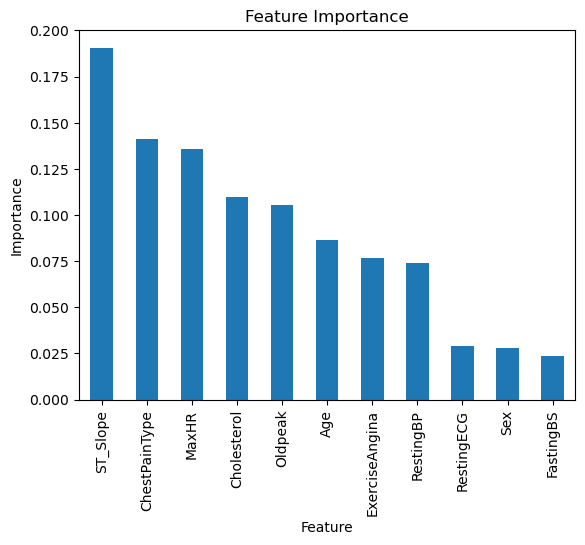

In [57]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf_scaled.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')

plt.show()

## Hyperparameter tuning

In [61]:
# n_estimators: number of trees in the random forest
n_estimators = np.arange(50,501,50)

# max_depth: the maximum number of leaves/branches in each decision tree
max_depth = np.arange(10,101,10)

max_depth = np.append(max_depth,None)

# min_samples_split: the number of samples a node must hold to split again
min_samples_split = np.arange(2,7,2)

# max_leaf_nodes: Maximum terminal leaf nodes that the decision tree can have
max_leaf_nodes = np.arange(2,27,2)

# max_features: maximum number of features that will be used in the decision tree
max_features = ['sqrt', 'log2', None]


param_grid = {"n_estimators" : n_estimators,
             "max_depth" :  max_depth,
             "min_samples_split" : min_samples_split,
             "max_leaf_nodes" : max_leaf_nodes,
             "max_features" : max_features,
             }

In [65]:
rf_tuned = RandomForestClassifier()

rf_tuned = RandomizedSearchCV(rf_tuned,param_grid)

rf_tuned.fit(X_train_scaled,y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], dtype=object),
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26]),
                                        'min_samples_split': array([2, 4, 6]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])})

In [66]:
y_pred_tuned = rf_tuned.predict(X_test)

In [67]:
rf_tuned.best_estimator_

RandomForestClassifier(max_depth=70, max_features='log2', max_leaf_nodes=26,
                       min_samples_split=6, n_estimators=250)

In [68]:
acc_tuned = accuracy_score(y_test,y_pred_tuned)
acc_tuned

0.8712871287128713

In [70]:
print(classification_report(y_test,y_pred_scaled))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       136
           1       0.87      0.90      0.88       167

    accuracy                           0.87       303
   macro avg       0.87      0.87      0.87       303
weighted avg       0.87      0.87      0.87       303



In [73]:
# n_estimators: number of trees in the random forest
n_estimators = np.arange(200,501,50)

# max_depth: the maximum number of leaves/branches in each decision tree
max_depth = np.arange(50,101,10)

max_depth = np.append(max_depth,None)

# min_samples_split: the number of samples a node must hold to split again
min_samples_split = np.arange(4,10,2)

# max_leaf_nodes: Maximum terminal leaf nodes that the decision tree can have
max_leaf_nodes = np.arange(24,32,2)

# max_features: maximum number of features that will be used in the decision tree
max_features = ['sqrt', 'log2', None]


param_grid = {"n_estimators" : n_estimators,
             "max_depth" :  max_depth,
             "min_samples_split" : min_samples_split,
             "max_leaf_nodes" : max_leaf_nodes,
             "max_features" : max_features,
             }

In [ ]:
rf_grid = RandomForestClassifier()

rf_tuned = GridSearchCV(rf_grid,param_grid)

rf_tuned.fit(X_train_scaled,y_train)